# DATA LOADING

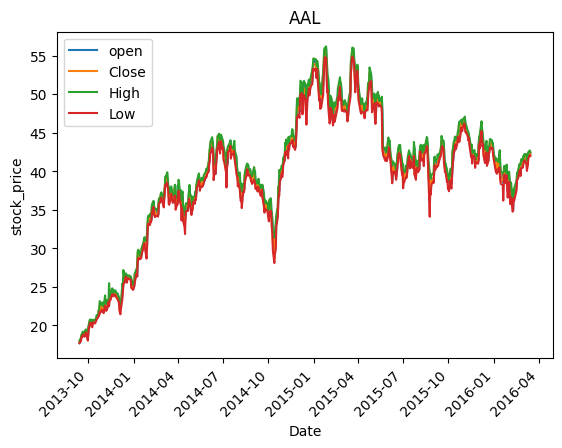

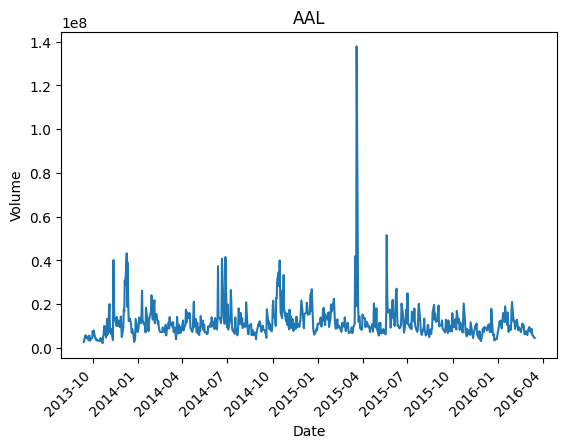

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import r2_score
import seaborn as sns
import data_load as dl
import pickle



data = dl.data_load(sname = "AAL",file = "all_stocks_5yr.csv",index_start = 150,index_end = 780 )
#data1 = dl.data_load(sname = "Google",file = "GOOGL_2006-01-01_to_2018-01-01.csv",index_start = 1,index_end = 780 )

# Feature Engineering

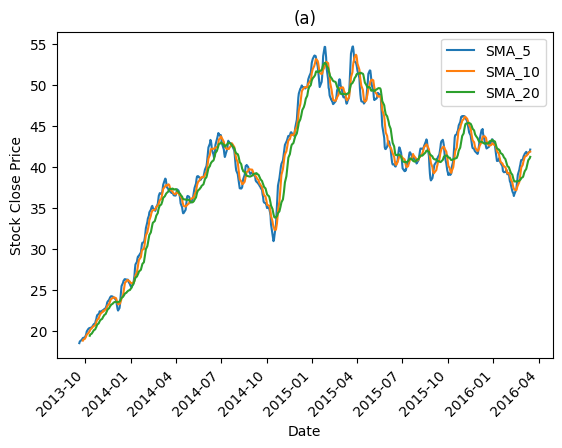

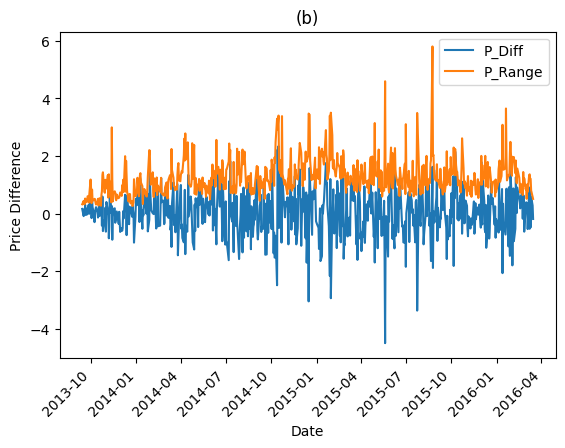

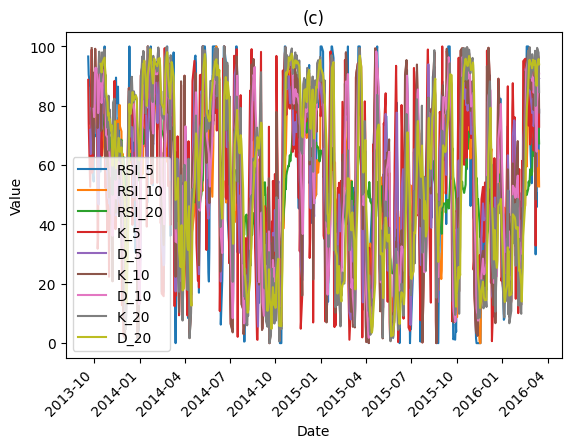

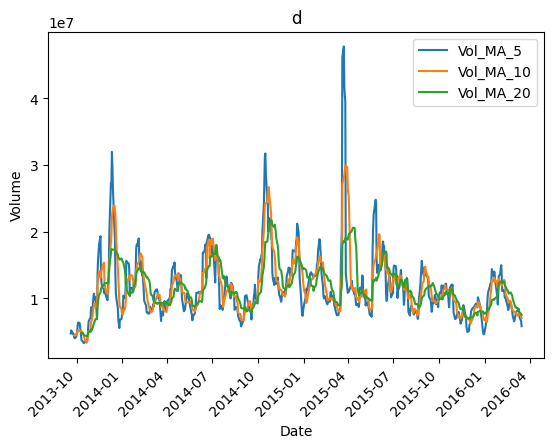

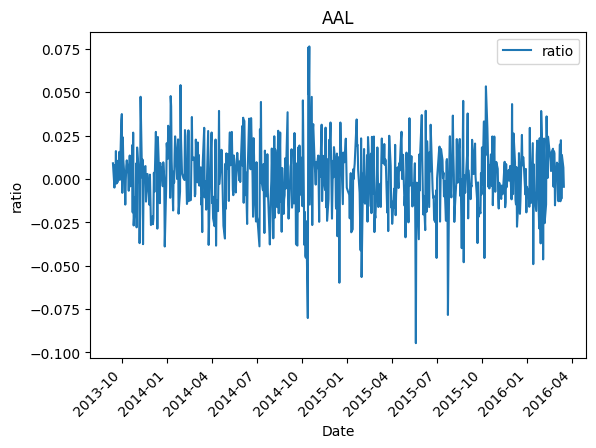

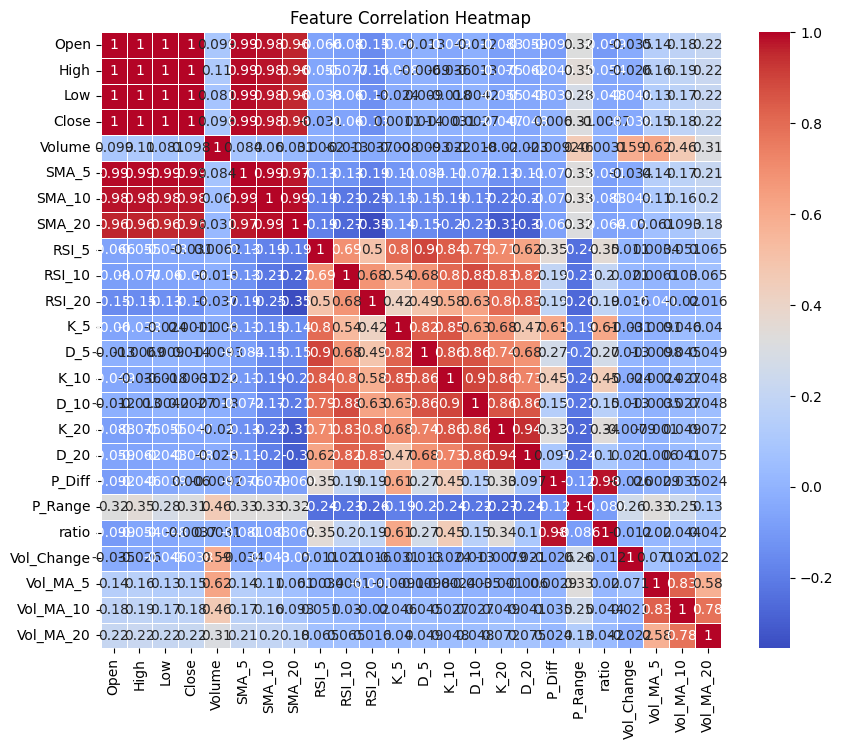

In [37]:

data = dl.feature_engineering(data,window = [5,10,20], d_window = 3)
df_main = data

# Build target variable and normalization

In [38]:
with pd.option_context('mode.chained_assignment', None):
    data,scalers = dl.Minmax(data)
data.head(5)

print(scalers)

data size =  (608, 25)
{'Open': MinMaxScaler(feature_range=(-1, 1)), 'High': MinMaxScaler(feature_range=(-1, 1)), 'Low': MinMaxScaler(feature_range=(-1, 1)), 'Close': MinMaxScaler(feature_range=(-1, 1)), 'Volume': MinMaxScaler(feature_range=(-1, 1)), 'SMA_5': MinMaxScaler(feature_range=(-1, 1)), 'SMA_10': MinMaxScaler(feature_range=(-1, 1)), 'SMA_20': MinMaxScaler(feature_range=(-1, 1)), 'RSI_5': MinMaxScaler(feature_range=(-1, 1)), 'RSI_10': MinMaxScaler(feature_range=(-1, 1)), 'RSI_20': MinMaxScaler(feature_range=(-1, 1)), 'K_5': MinMaxScaler(feature_range=(-1, 1)), 'D_5': MinMaxScaler(feature_range=(-1, 1)), 'K_10': MinMaxScaler(feature_range=(-1, 1)), 'D_10': MinMaxScaler(feature_range=(-1, 1)), 'K_20': MinMaxScaler(feature_range=(-1, 1)), 'D_20': MinMaxScaler(feature_range=(-1, 1)), 'P_Diff': MinMaxScaler(feature_range=(-1, 1)), 'P_Range': MinMaxScaler(feature_range=(-1, 1)), 'ratio': MinMaxScaler(feature_range=(-1, 1)), 'Vol_Change': MinMaxScaler(feature_range=(-1, 1)), 'Vol_MA_5

In [39]:
n_components = 10
PCA_df = dl.PCA_plus(data,n_components=n_components)
PCA_df.head(4)

Proportion of principal components: [0.48382217 0.2895165  0.0722728  0.05400129 0.03105337 0.01504598
 0.01206536 0.01071881 0.00688244 0.00667018]
principal components 1: Proportion of variance = 0.4838, Cumulative proportion of variance = 0.4838
principal components 2: Proportion of variance = 0.2895, Cumulative proportion of variance = 0.7733
principal components 3: Proportion of variance = 0.0723, Cumulative proportion of variance = 0.8456
principal components 4: Proportion of variance = 0.0540, Cumulative proportion of variance = 0.8996
principal components 5: Proportion of variance = 0.0311, Cumulative proportion of variance = 0.9307
principal components 6: Proportion of variance = 0.0150, Cumulative proportion of variance = 0.9457
principal components 7: Proportion of variance = 0.0121, Cumulative proportion of variance = 0.9578
principal components 8: Proportion of variance = 0.0107, Cumulative proportion of variance = 0.9685
principal components 9: Proportion of variance = 0.

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,target
0,-2.204700,2.812716,-0.165021,-0.846705,-0.056387,0.181171,0.081822,-0.367701,-0.186069,-0.038451,0.027224
1,-1.897971,2.854772,-0.210592,-0.867546,0.243122,-0.147606,0.099894,-0.118101,0.046694,0.108648,0.134979
2,-1.874729,2.866117,-0.229302,-0.878823,0.041589,-0.060655,-0.029559,0.011265,0.038283,0.140331,0.264592
3,-2.240862,2.761262,0.146467,-0.890090,-0.212049,-0.004132,0.104141,-0.223761,-0.030055,0.035767,0.056973


# Model 
## [RNN,LSTM,GRU AND RCNN]

In [40]:

class LSTM_GRU_RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim,bidirectional=False,model = "LSTM"):
        super(LSTM_GRU_RNN, self).__init__()
        self.model = model
        # Hidden dimensions
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional
        # Number of hidden layers
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=0.5)  # Dropout layer，p was drop probability,
        self.relu = nn.ReLU()  # Add a ReLU activation
        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True,bidirectional=bidirectional)
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=bidirectional)
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=bidirectional)

        # fc layer after LSTM，this project is a regression problem，
        # so it cann't add activation function after fc2, but you can add it after fc1
        if self.bidirectional == False:
            self.fc1 = nn.Linear(hidden_dim, hidden_dim//2) 
        else:
            self.fc1 = nn.Linear(hidden_dim*2, hidden_dim//2) 
            
        self.fc2 = nn.Linear( hidden_dim//2, output_dim) 
    def forward(self, x):
        if self.bidirectional == False:
            # Initialize hidden state with zeros   
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_() 
            # x.size(0) is batch_size
            # Initialize cell state
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        else:
            h0 = torch.zeros(2 * self.num_layers, x.size(0), self.hidden_dim).requires_grad_() # Multiply num_layers by 2 for bidirectional
            c0 = torch.zeros(2 * self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # GRU don't need cell state
        if self.model == "LSTM":
            out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        elif self.model == "GRU":
            out, hn = self.gru(x, h0.detach())
        elif self.model == "RNN":
            out, hn = self.rnn(x, h0.detach())
        else:
              # Handle unknown model name
            raise ValueError("Unknown model name" )
        out = self.dropout(out)
        out = self.fc1(out) 
        out = self.relu(out)  # Apply ReLU activation
        out = self.fc2(out) 
        return out
    
# model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers,bidirectional=True)
# optimiser = torch.optim.Adam(model.parameters(), lr=0.01) # Adam
# loss_fn = torch.nn.MSELoss(reduction='mean')             # mse

# # check the model structure
# print(model)
# for i in range(len(list(model.parameters()))):
#     print(list(model.parameters())[i].size())


# Parameters

In [41]:
input_dim = n_components      # the dimension of feature = PCA acount
hidden_dim = 128   # the number of neuron in hidden state 
num_layers = 3     # the number of LSTM layer
output_dim = 1     #  the dimension of output
                   #（这是预测股票价格，所以这里特征数是1，如果预测一个单词，那么这里是one-hot向量的编码长度）
seq = 10        # length
num_epochs = 1000
means = 10          # the running times
test_set_size = 30

# Train Test Split

In [42]:
trainX, testX, trainY, testY = dl.train_test_set(PCA_df,input_dim= input_dim,seq = seq,test_set_size = 30)

data_feat shape: (598, 10, 10)
data_target shape (598, 10)
testset length 30
trainset length 568
trainX size: torch.Size([568, 10, 10])
testX size: torch.Size([30, 10, 10])
trainY size: torch.Size([568, 10, 1])
testY size: torch.Size([30, 10, 1])


# Training Process

In [44]:
train_pred_lst,test_pred_lst = dl.run_train_test(trainX,trainY,testX,
                                         input_dim = input_dim, hidden_dim = hidden_dim, num_layers = num_layers, 
                                        output_dim = output_dim,seq = seq,num_epochs = num_epochs,means = means,
                                        model_name = "LSTM",bidirectional=True,name="AAL")

Epoch  20 MSE:  0.013935771770775318
Epoch  40 MSE:  0.007549803704023361
Epoch  60 MSE:  0.006538592744618654
Epoch  80 MSE:  0.005672818049788475
y_train_pred size= torch.Size([568, 10, 1])


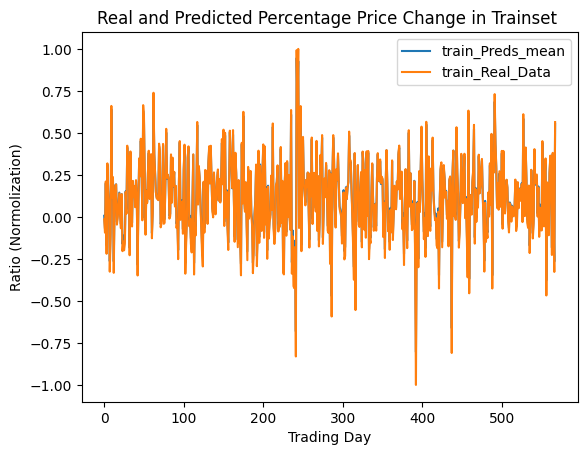

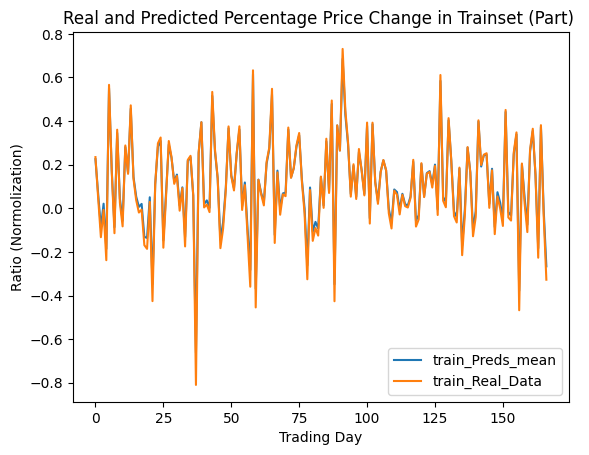

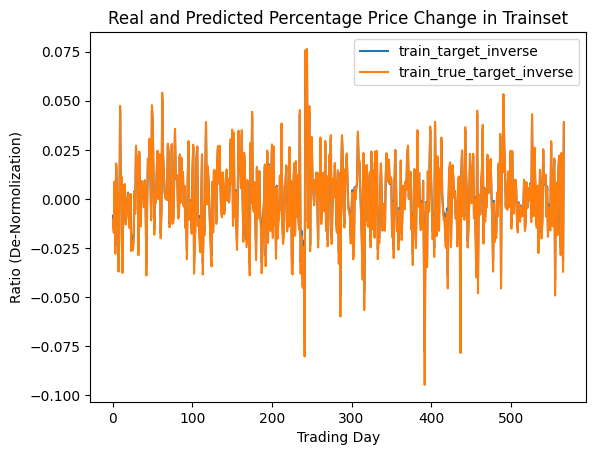

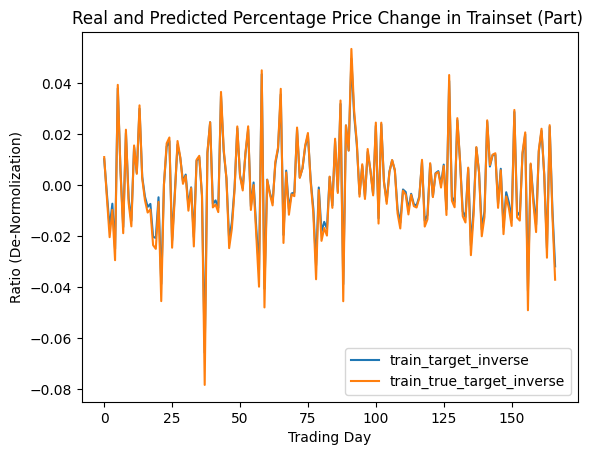

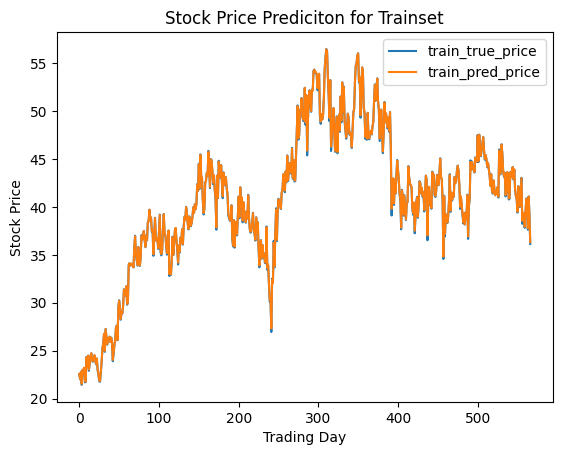

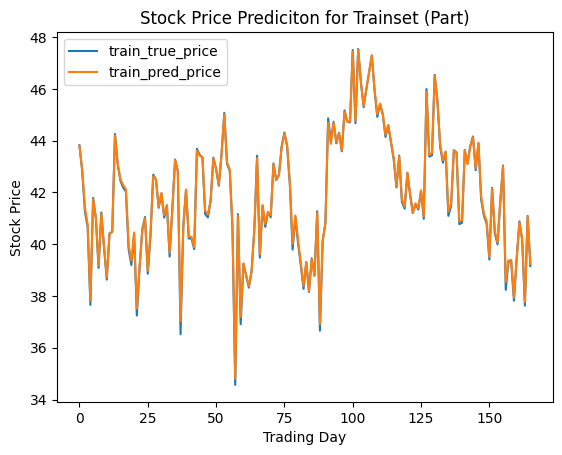

train_MSE: 0.009569519199430943
train_RMSE: 0.09782391786575317
train_rRMSE: 0.0027900540735572577
train_MAE: 0.06617237627506256
train_R-squared (R²): 0.999824886917586
train Win-Loss Ratio: 140.5
#######################################


In [45]:
train_pred_file = "AAL_LSTM_train_pred_ind10_hd34_nl2_outd1_seq10_ne1000_means10.pkl"
train_pred_price, train_true_price = dl.train_matrics(train_pred_file, data, trainY,seq=seq, scalers = scalers, 
                 test_set_size = test_set_size,plot = True)

# Validation Process

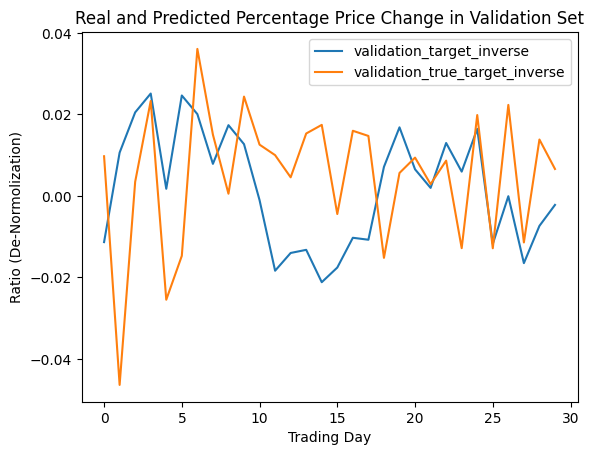

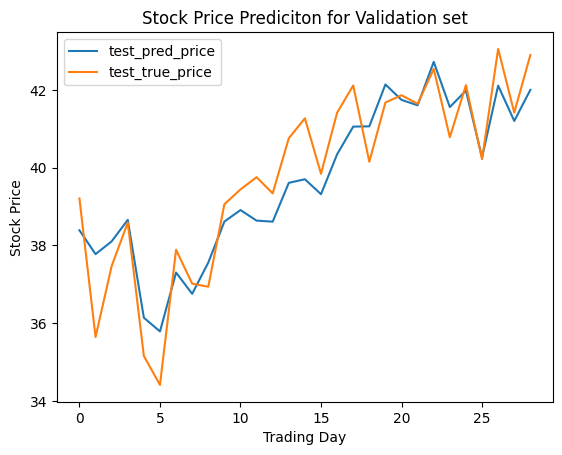

test_MSE: 0.7334554195404053
test_RMSE: 0.85642009973526
test_rRMSE: 0.09919492155313492
test_MAE: 0.7028265595436096
test_R-squared (R²): 0.8622906449674108
test_Win-Loss Ratio: 6.0
#######################################


In [46]:
test_pred_file = "AAL_LSTM_test_pred_ind10_hd34_nl2_outd1_seq10_ne1000_means10.pkl"
test_pred_price, test_true_price = dl.test_matrics(test_pred_file, data, testY,scalers = scalers, 
                 test_set_size = test_set_size,plot = True)


# Hyperparameter Adjust
## 1. bi-direction or not


test_MSE: 0.7334554195404053
test_RMSE: 0.85642009973526
test_rRMSE: 0.09919492155313492
test_MAE: 0.7028265595436096
test_R-squared (R²): 0.8622906449674108
test_Win-Loss Ratio: 6.0
#######################################
test_MSE: 0.5620408654212952
test_RMSE: 0.7496938705444336
test_rRMSE: 0.08683335036039352
test_MAE: 0.6223260164260864
test_R-squared (R²): 0.8944744641910802
test_Win-Loss Ratio: 3.0
#######################################


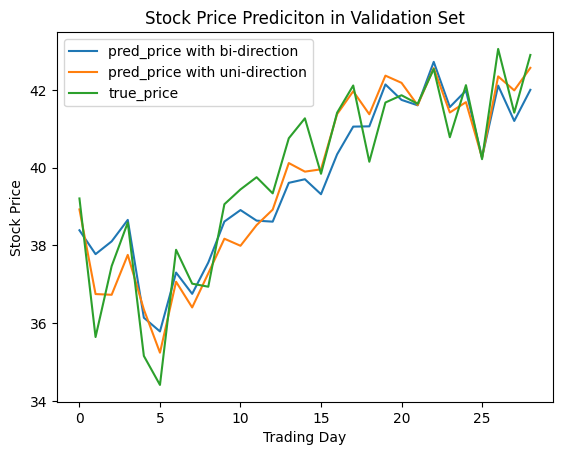

In [48]:
#bi-direction
test_pred_file = "AAL_LSTM_test_pred_ind10_hd34_nl2_outd1_seq10_ne1000_means10.pkl"
test_pred_price, test_true_price = dl.test_matrics(test_pred_file, data, testY,scalers = scalers, 
                 test_set_size = test_set_size,plot = False)
#uni-direction
test_pred_file_nobi = "AAL_LSTM_test_pred_ind10_hd34_nl2_outd1_seq10_ne1000_means10_nobi.pkl"
test_pred_price_nobi, test_true_price = dl.test_matrics(test_pred_file_nobi, data, testY,scalers = scalers, 
                 test_set_size = test_set_size,plot = False)

plt.plot(test_pred_price, label="pred_price with bi-direction") 
plt.plot(test_pred_price_nobi, label="pred_price with uni-direction")
plt.plot(test_true_price, label="true_price")
plt.title("Stock Price Prediciton in Validation Set")
plt.ylabel("Stock Price")
plt.xlabel("Trading Day")  
plt.legend()    
plt.show()


## 2. Stacked or not

test_MSE: 0.8363980650901794
test_RMSE: 0.9145480394363403
test_rRMSE: 0.10592759400606155
test_MAE: 0.7757677435874939
test_R-squared (R²): 0.842962712911768
test_Win-Loss Ratio: 13.0
#######################################
test_MSE: 0.7565695643424988
test_RMSE: 0.8698100447654724
test_rRMSE: 0.10074581205844879
test_MAE: 0.7187339663505554
test_R-squared (R²): 0.8579508609377882
test_Win-Loss Ratio: 13.0
#######################################
test_MSE: 0.6151366829872131
test_RMSE: 0.784306526184082
test_rRMSE: 0.0908423662185669
test_MAE: 0.6319413185119629
test_R-squared (R²): 0.884505488020287
test_Win-Loss Ratio: 4.6
#######################################
test_MSE: 0.5817137360572815
test_RMSE: 0.7627016305923462
test_rRMSE: 0.08833997696638107
test_MAE: 0.5863972306251526
test_R-squared (R²): 0.8907807857584663
test_Win-Loss Ratio: 4.6
#######################################


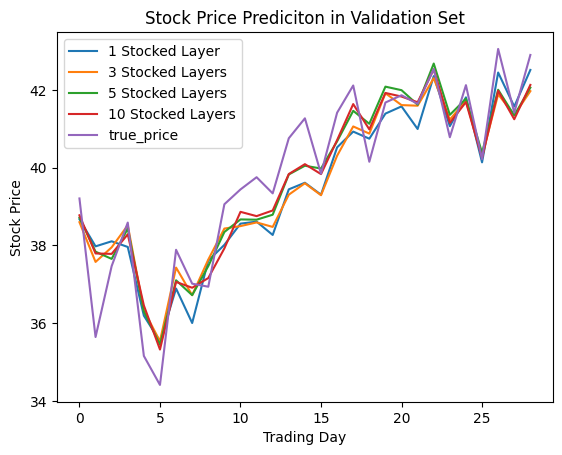

In [10]:
#stacked layer 1
test_pred_file1 = "AAL_LSTM_test_pred_ind10_hd34_nl1_outd1_seq10_ne1000_means10.pkl"
test_pred_price1, test_true_price = dl.test_matrics(test_pred_file1, data, testY,scalers = scalers, 
                 test_set_size = test_set_size,plot = False)
#stacked layer 3
test_pred_file3 = "AAL_LSTM_test_pred_ind10_hd34_nl3_outd1_seq10_ne1000_means10.pkl"
test_pred_price3, test_true_price = dl.test_matrics(test_pred_file3, data, testY,scalers = scalers, 
                 test_set_size = test_set_size,plot = False)
#stacked layer 5
test_pred_file5 = "AAL_LSTM_test_pred_ind10_hd34_nl5_outd1_seq10_ne1000_means10.pkl"
test_pred_price5, test_true_price = dl.test_matrics(test_pred_file5, data, testY,scalers = scalers, 
                 test_set_size = test_set_size,plot = False)
#stacked layer 10
test_pred_file10 = "AAL_LSTM_test_pred_ind10_hd34_nl10_outd1_seq10_ne1000_means10.pkl"
test_pred_price10, test_true_price = dl.test_matrics(test_pred_file10, data, testY,scalers = scalers, 
                 test_set_size = test_set_size,plot = False)

plt.plot(test_pred_price1, label="1 Stocked Layer") 
plt.plot(test_pred_price3, label="3 Stocked Layers") 
plt.plot(test_pred_price5, label="5 Stocked Layers") 
plt.plot(test_pred_price10, label="10 Stocked Layers") 
plt.plot(test_true_price, label="true_price")
plt.title("Stock Price Prediciton in Validation Set")
plt.ylabel("Stock Price")
plt.xlabel("Trading Day")  
plt.legend()    
plt.show()

## 3. Sequence

test_MSE: 0.7323002815246582
test_RMSE: 0.8557454347610474
test_rRMSE: 0.09911677986383438
test_MAE: 0.7033810019493103
test_R-squared (R²): 0.8625075297606617
test_Win-Loss Ratio: 4.6
#######################################
test_MSE: 0.7165514230728149
test_RMSE: 0.8464936017990112
test_rRMSE: 0.09804518520832062
test_MAE: 0.6855872869491577
test_R-squared (R²): 0.8654644353103322
test_Win-Loss Ratio: 4.6
#######################################
test_MSE: 0.7565695643424988
test_RMSE: 0.8698100447654724
test_rRMSE: 0.10074581205844879
test_MAE: 0.7187339663505554
test_R-squared (R²): 0.8579508609377882
test_Win-Loss Ratio: 13.0
#######################################
test_MSE: 0.6565079689025879
test_RMSE: 0.810251772403717
test_rRMSE: 0.09384747594594955
test_MAE: 0.6666098237037659
test_R-squared (R²): 0.8767378528945401
test_Win-Loss Ratio: 8.333333333333334
#######################################
test_MSE: 0.8097088932991028
test_RMSE: 0.8998382687568665
test_rRMSE: 0.1042238399386

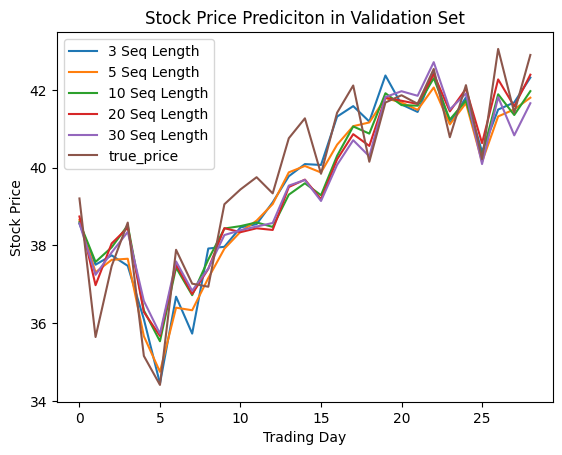

In [49]:
# Sequence Length 3
test_pred_file3 = "AAL_LSTM_test_pred_ind10_hd34_nl3_outd1_seq3_ne1000_means10.pkl"
test_pred_price3, test_true_price = dl.test_matrics(test_pred_file3, data, testY,scalers = scalers, 
                 test_set_size = test_set_size,plot = False)
# Sequence Length 5
test_pred_file5 = "AAL_LSTM_test_pred_ind10_hd34_nl3_outd1_seq5_ne1000_means10.pkl"
test_pred_price5, test_true_price = dl.test_matrics(test_pred_file5, data, testY,scalers = scalers, 
                 test_set_size = test_set_size,plot = False)
# Sequence Length 10
test_pred_file10 = "AAL_LSTM_test_pred_ind10_hd34_nl3_outd1_seq10_ne1000_means10.pkl"
test_pred_price10, test_true_price = dl.test_matrics(test_pred_file10, data, testY,scalers = scalers, 
                 test_set_size = test_set_size,plot = False)
# Sequence Length 20
test_pred_file20 = "AAL_LSTM_test_pred_ind10_hd34_nl3_outd1_seq20_ne1000_means10.pkl"
test_pred_price20, test_true_price = dl.test_matrics(test_pred_file20, data, testY,scalers = scalers, 
                 test_set_size = test_set_size,plot = False)
# Sequence Length 30
test_pred_file30 = "AAL_LSTM_test_pred_ind10_hd34_nl3_outd1_seq30_ne1000_means10.pkl"
test_pred_price30, test_true_price = dl.test_matrics(test_pred_file30, data, testY,scalers = scalers, 
                 test_set_size = test_set_size,plot = False)
plt.plot(test_pred_price3, label="3 Seq Length") 
plt.plot(test_pred_price5, label="5 Seq Length") 
plt.plot(test_pred_price10, label="10 Seq Length") 
plt.plot(test_pred_price20, label="20 Seq Length") 
plt.plot(test_pred_price30, label="30 Seq Length") 
plt.plot(test_true_price, label="true_price")
plt.title("Stock Price Prediciton in Validation Set")
plt.ylabel("Stock Price")
plt.xlabel("Trading Day")  
plt.legend()    
plt.show()

## 4. Hidden State

test_MSE: 0.7724512219429016
test_RMSE: 0.8788920640945435
test_rRMSE: 0.10179773718118668
test_MAE: 0.717435359954834
test_R-squared (R²): 0.8549690241055248
test_Win-Loss Ratio: 6.0
#######################################
test_MSE: 0.677574872970581
test_RMSE: 0.8231493830680847
test_rRMSE: 0.09534133970737457
test_MAE: 0.6790626645088196
test_R-squared (R²): 0.8727824453582876
test_Win-Loss Ratio: 8.333333333333334
#######################################
test_MSE: 0.45220986008644104
test_RMSE: 0.6724655032157898
test_rRMSE: 0.0778883695602417
test_MAE: 0.5386220812797546
test_R-squared (R²): 0.9150956871615525
test_Win-Loss Ratio: 4.6
#######################################
test_MSE: 0.4325907528400421
test_RMSE: 0.6577163338661194
test_rRMSE: 0.07618004828691483
test_MAE: 0.576934814453125
test_R-squared (R²): 0.9187792584277582
test_Win-Loss Ratio: 6.0
#######################################


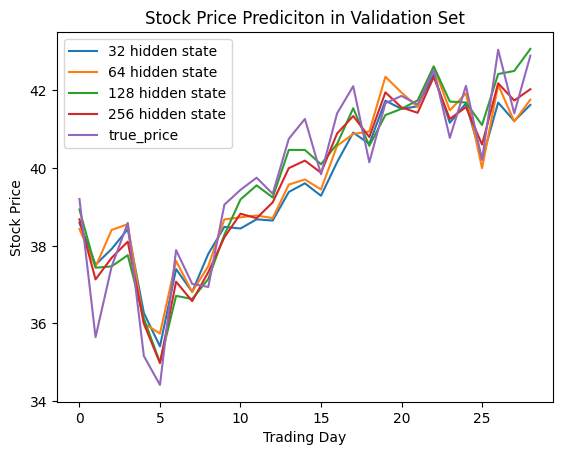

In [50]:
# Hidden State 32
test_pred_file32 = "AAL_LSTM_test_pred_ind10_hd32_nl3_outd1_seq10_ne1000_means10.pkl"
test_pred_price32, test_true_price = dl.test_matrics(test_pred_file32, data, testY,scalers = scalers, 
                 test_set_size = test_set_size,plot = False)
# Hidden State 64
test_pred_file64 = "AAL_LSTM_test_pred_ind10_hd64_nl3_outd1_seq10_ne1000_means10.pkl"
test_pred_price64, test_true_price = dl.test_matrics(test_pred_file64, data, testY,scalers = scalers, 
                 test_set_size = test_set_size,plot = False)
# Hidden State 128
test_pred_file128 = "AAL_LSTM_test_pred_ind10_hd128_nl3_outd1_seq10_ne1000_means10.pkl"
test_pred_price128, test_true_price = dl.test_matrics(test_pred_file128, data, testY,scalers = scalers, 
                 test_set_size = test_set_size,plot = False)
# Hidden State 256
test_pred_file256 = "AAL_LSTM_test_pred_ind10_hd256_nl3_outd1_seq10_ne1000_means10.pkl"
test_pred_price256, test_true_price = dl.test_matrics(test_pred_file256, data, testY,scalers = scalers, 
                 test_set_size = test_set_size,plot = False)

plt.plot(test_pred_price32, label="32 hidden state") 
plt.plot(test_pred_price64, label="64 hidden state") 
plt.plot(test_pred_price128, label="128 hidden state") 
plt.plot(test_pred_price256, label="256 hidden state")  
plt.plot(test_true_price, label="true_price")
plt.title("Stock Price Prediciton in Validation Set")
plt.ylabel("Stock Price")
plt.xlabel("Trading Day")  
plt.legend()    
plt.show()

# Model Comparison

test_MSE: 0.47806012630462646
test_RMSE: 0.6914189457893372
test_rRMSE: 0.08008365333080292
test_MAE: 0.6040453314781189
test_R-squared (R²): 0.9102421965003771
test_Win-Loss Ratio: 4.6
#######################################
test_MSE: 0.45220986008644104
test_RMSE: 0.6724655032157898
test_rRMSE: 0.0778883695602417
test_MAE: 0.5386220812797546
test_R-squared (R²): 0.9150956871615525
test_Win-Loss Ratio: 4.6
#######################################
test_MSE: 0.6996284127235413
test_RMSE: 0.8364379405975342
test_rRMSE: 0.0968804880976677
test_MAE: 0.7096534967422485
test_R-squared (R²): 0.86864179510004
test_Win-Loss Ratio: 1.8
#######################################


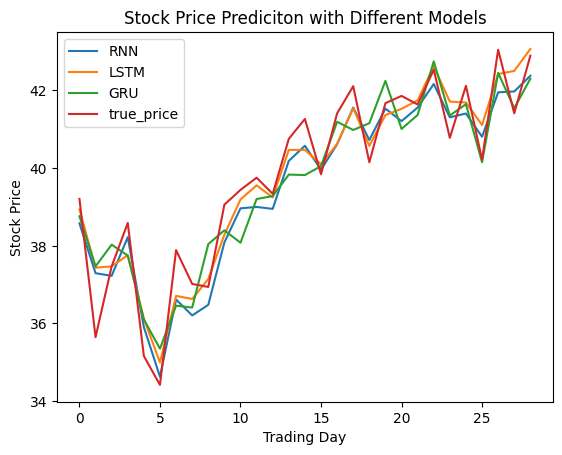

In [51]:
#model RNN
test_pred_file_RNN = "AAL_RNN_test_pred_ind10_hd128_nl3_outd1_seq10_ne1000_means10.pkl"
test_pred_price_RNN, test_true_price = dl.test_matrics(test_pred_file_RNN, data, testY,scalers = scalers, 
                 test_set_size = test_set_size,plot = False)
#model LSTM
test_pred_file_LSTM = "AAL_LSTM_test_pred_ind10_hd128_nl3_outd1_seq10_ne1000_means10.pkl"
test_pred_price_LSTM, test_true_price = dl.test_matrics(test_pred_file_LSTM, data, testY,scalers = scalers, 
                 test_set_size = test_set_size,plot = False)
#model GRU
test_pred_file_GRU = "AAL_GRU_test_pred_ind10_hd128_nl3_outd1_seq10_ne1000_means10.pkl"
test_pred_price_GRU, test_true_price = dl.test_matrics(test_pred_file_GRU, data, testY,scalers = scalers, 
                 test_set_size = test_set_size,plot = False)


plt.plot(test_pred_price_RNN, label="RNN") 
plt.plot(test_pred_price_LSTM, label="LSTM") 
plt.plot(test_pred_price_GRU, label="GRU") 
plt.plot(test_true_price, label="true_price")
plt.title("Stock Price Prediciton with Different Models")
plt.ylabel("Stock Price")
plt.xlabel("Trading Day")  
plt.legend()    
plt.show()

# Test Process

In [52]:
data_AAL = dl.data_load(sname = "AAL",file = "AAL.csv",index_start = 0,index_end = 650,plot =False)
data_DAL = dl.data_load(sname = "DAL",file = "DAL.csv",index_start = 0,index_end = 650,plot =False)
data_UAL = dl.data_load(sname = "UAL",file = "UAL.csv",index_start = 0,index_end = 650,plot =False)
data_LUV = dl.data_load(sname = "LUV",file = "LUV.csv",index_start = 0,index_end = 650,plot =False)
print(data_AAL.shape)
data_AAL = dl.feature_engineering(data_AAL,window = [5,10,20], d_window = 3,plot =False)
data_DAL = dl.feature_engineering(data_DAL,window = [5,10,20], d_window = 3,plot =False)
data_UAL = dl.feature_engineering(data_UAL,window = [5,10,20], d_window = 3,plot =False)
data_LUV = dl.feature_engineering(data_LUV,window = [5,10,20], d_window = 3,plot =False)
print(data_AAL.shape)
with pd.option_context('mode.chained_assignment', None):
    data_AAL,scalers_AAL = dl.Minmax(data_AAL)
    data_DAL,scalers_DAL = dl.Minmax(data_DAL)
    data_UAL,scalers_UAL = dl.Minmax(data_UAL)
    data_LUV,scalers_LUV = dl.Minmax(data_LUV)
print(data_AAL.shape)
    
PCA_df_AAL = dl.PCA_plus(data_AAL,n_components=n_components)
PCA_df_DAL = dl.PCA_plus(data_DAL,n_components=n_components)
PCA_df_UAL = dl.PCA_plus(data_UAL,n_components=n_components)
PCA_df_LUV = dl.PCA_plus(data_LUV,n_components=n_components)  
print(data_AAL.shape)  

_, testX_AAL, _, testY_AAL = dl.train_test_set(PCA_df_AAL,input_dim= input_dim,seq = seq,test_set_size = 30)
_, testX_DAL, _, testY_DAL = dl.train_test_set(PCA_df_DAL,input_dim= input_dim,seq = seq,test_set_size = 30)
_, testX_UAL, _, testY_UAL = dl.train_test_set(PCA_df_UAL,input_dim= input_dim,seq = seq,test_set_size = 30)
_, testX_LUV, _, testY_LUV = dl.train_test_set(PCA_df_LUV,input_dim= input_dim,seq = seq,test_set_size = 30)



(650, 6)
(650, 24)
data size =  (628, 25)
data size =  (628, 25)
data size =  (628, 25)
data size =  (628, 25)
(628, 25)
Proportion of principal components: [0.49243754 0.2718946  0.07359593 0.0602489  0.03127979 0.01530988
 0.01219374 0.01057388 0.00738839 0.00674674]
principal components 1: Proportion of variance = 0.4924, Cumulative proportion of variance = 0.4924
principal components 2: Proportion of variance = 0.2719, Cumulative proportion of variance = 0.7643
principal components 3: Proportion of variance = 0.0736, Cumulative proportion of variance = 0.8379
principal components 4: Proportion of variance = 0.0602, Cumulative proportion of variance = 0.8982
principal components 5: Proportion of variance = 0.0313, Cumulative proportion of variance = 0.9295
principal components 6: Proportion of variance = 0.0153, Cumulative proportion of variance = 0.9448
principal components 7: Proportion of variance = 0.0122, Cumulative proportion of variance = 0.9570
principal components 8: Propor

Epoch  20 MSE:  0.02061840333044529
Epoch  40 MSE:  0.0077587757259607315
Epoch  60 MSE:  0.006704298313707113
Epoch  80 MSE:  0.006017139647156
Epoch  100 MSE:  0.005232106428593397
Epoch  120 MSE:  0.0039057577960193157
Epoch  140 MSE:  0.0031602883245795965
Epoch  160 MSE:  0.0017585274763405323
Epoch  180 MSE:  0.0010766683844849467
Epoch  200 MSE:  0.0007622661651112139
Epoch  220 MSE:  0.0005603784811682999
Epoch  240 MSE:  0.0004960038349963725
Epoch  260 MSE:  0.0004476778849493712
Epoch  280 MSE:  0.00046497525181621313
Epoch  20 MSE:  0.026361260563135147
Epoch  40 MSE:  0.009018107317388058
Epoch  60 MSE:  0.007211360149085522
Epoch  80 MSE:  0.006346418987959623
Epoch  100 MSE:  0.005508926697075367
Epoch  120 MSE:  0.004338980186730623
Epoch  140 MSE:  0.002648004563525319
Epoch  160 MSE:  0.0014473170740529895
Epoch  180 MSE:  0.0008641244494356215
Epoch  200 MSE:  0.0006490868981927633
Epoch  220 MSE:  0.000572210003156215
Epoch  240 MSE:  0.0005296046729199588
Epoch  26

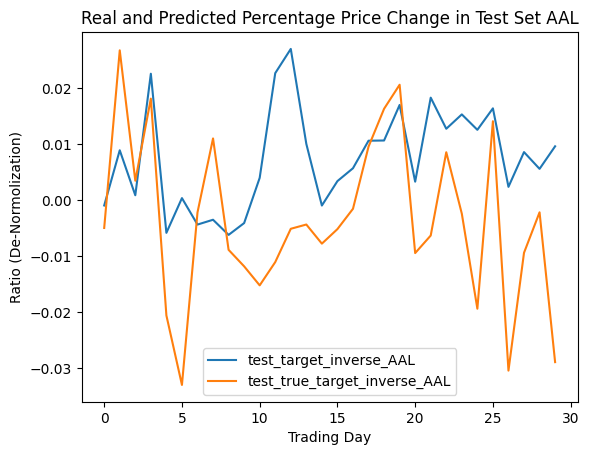

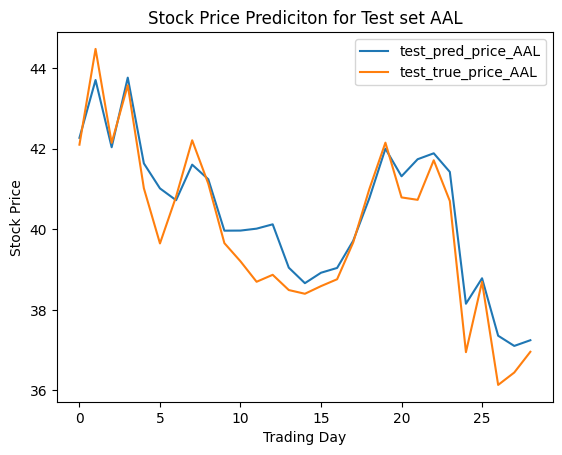

test_MSE_AAL: 0.4564695656299591
test_RMSE_AAL: 0.6756253242492676
test_rRMSE_AAL: 0.08101104199886322
test_MAE_AAL: 0.531276285648346
test_R-squared(R²)_AAL: 0.8896987475489274
test_Win-Loss-Ratio_AAL: 4.6
#######################################


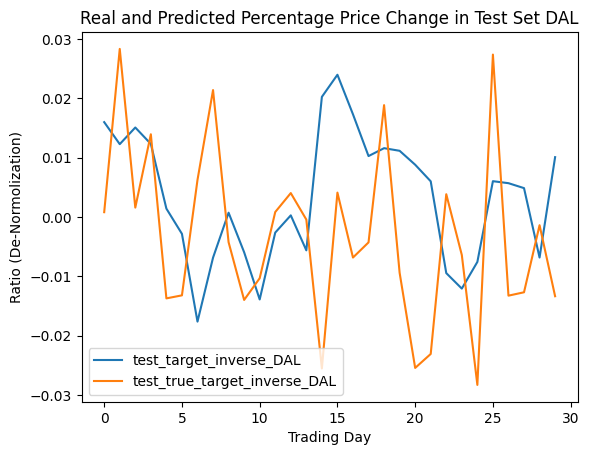

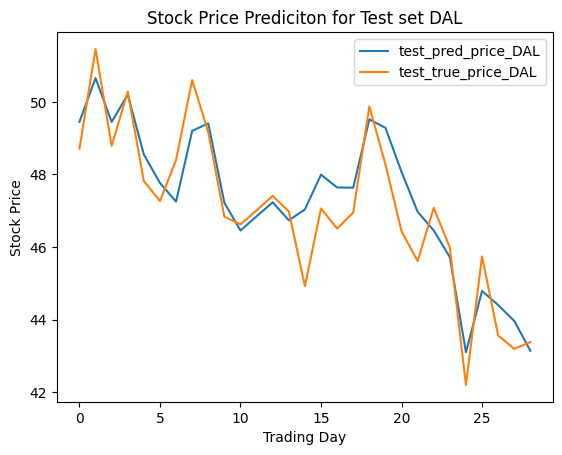

test_MSE_DAL: 0.7687092423439026
test_RMSE_DAL: 0.8767606616020203
test_rRMSE_DAL: 0.09470128268003464
test_MAE_DAL: 0.7321539521217346
test_R-squared(R²)_DAL: 0.8397919356705394
test_Win-Loss-Ratio_DAL: 3.6666666666666665
#######################################


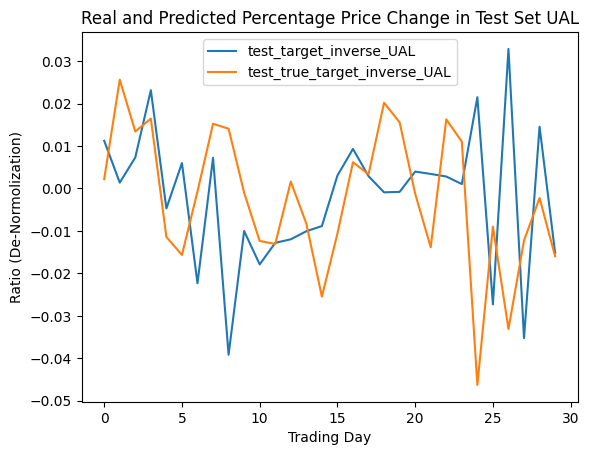

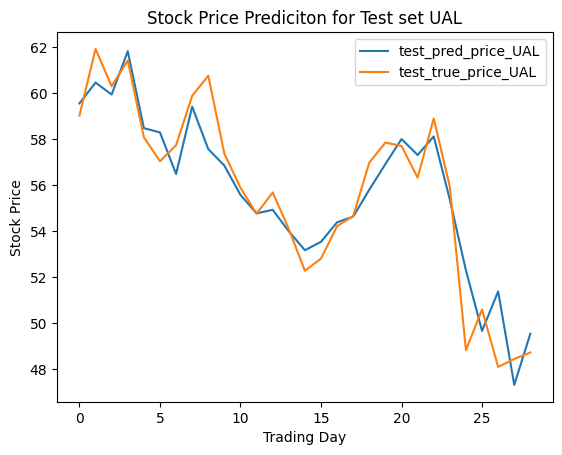

test_MSE_UAL: 1.6755141019821167
test_RMSE_UAL: 1.2944165468215942
test_rRMSE_UAL: 0.09363146871328354
test_MAE_UAL: 0.938186526298523
test_R-squared(R²)_UAL: 0.8899073041026533
test_Win-Loss-Ratio_UAL: 3.6666666666666665
#######################################


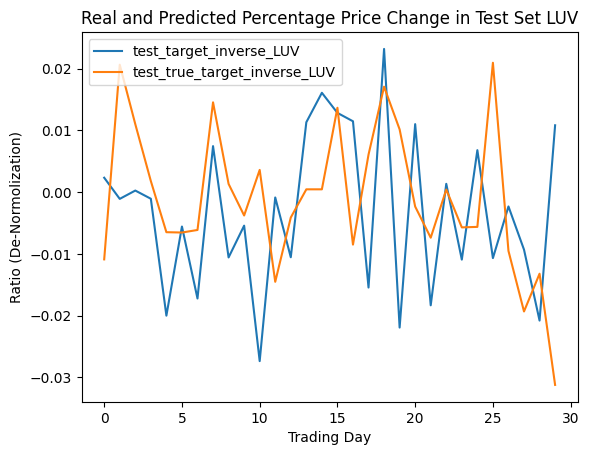

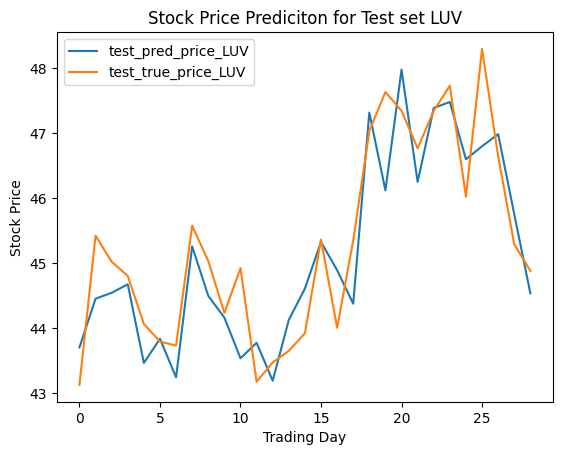

test_MSE_LUV: 0.46245697140693665
test_RMSE_LUV: 0.6800419092178345
test_rRMSE_LUV: 0.13163401186466217
test_MAE_LUV: 0.551267683506012
test_R-squared(R²)_LUV: 0.7876686835742236
test_Win-Loss-Ratio_LUV: 1.8
#######################################


In [12]:
test_pred_AAL_lst, test_pred_DAL_lst, test_pred_UAL_lst, test_pred_LUV_lst = dl.run_test2(
    trainX,trainY,testX_AAL,testX_DAL,testX_UAL,testX_LUV,
    input_dim = 10, hidden_dim = 128, num_layers = 3, 
    output_dim = 1,seq = 10,num_epochs = 1000,means = 10,
    model_name = "LSTM",bidirectional=True, 
    name=["AAL","DAL","UAL","LUV"])

test_pred_AAL_price, test_true_AAL_price =dl.test_matrics2(data_AAL,test_pred_AAL_lst,testY_AAL,scalers_AAL,
                 test_set_size = 30,plot=True,stock_name = "AAL")

test_pred_DAL_price, test_true_DAL_price =dl.test_matrics2(data_DAL,test_pred_DAL_lst,testY_DAL,scalers_DAL,
                 test_set_size = 30,plot=True,stock_name = "DAL")

test_pred_UAL_price, test_true_UAL_price =dl.test_matrics2(data_UAL,test_pred_UAL_lst,testY_UAL,scalers_UAL,
                 test_set_size = 30,plot=True,stock_name = "UAL")

test_pred_LUV_price, test_true_LUV_price =dl.test_matrics2(data_LUV,test_pred_LUV_lst,testY_LUV,scalers_LUV,
                 test_set_size = 30,plot=True,stock_name = "LUV")

# The entire learning process

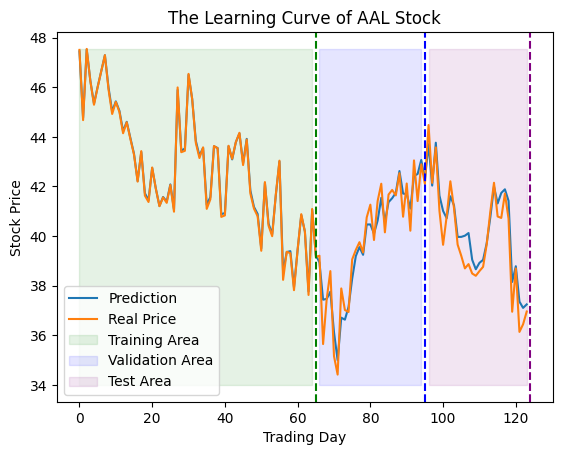

In [54]:
testp, testt = test_pred_AAL_price, test_true_AAL_price
valip,valit = test_pred_price128,test_true_price
trainp,traint = train_pred_price[500:-1], train_true_price[500:-1] 

p = np.concatenate((trainp, valip, testp), axis=0)
t = np.concatenate((traint, valit, testt), axis=0)

plt.plot(p, label="Prediction")
plt.plot(t, label="Real Price")

# Add vertical lines to mark different regions
plt.axvline(x=65, color='green', linestyle='--')
plt.axvline(x=95, color='blue', linestyle='--')
plt.axvline(x=len(p), color='purple', linestyle='--')

# Fill regions to the left of vertical lines with corresponding colors
plt.fill_between(np.arange(0, 65), 34, max(max(p), max(t)), color='green', alpha=0.1, label='Training Area')
plt.fill_between(np.arange(66, 95), 34, max(max(p), max(t)), color='blue', alpha=0.1, label='Validation Area')
plt.fill_between(np.arange(96, len(p)), 34, max(max(p), max(t)), color='purple', alpha=0.1, label='Test Area')

plt.title("The Learning Curve of AAL Stock")
plt.ylabel("Stock Price")
plt.xlabel("Trading Day")
plt.legend()
plt.show()

